Multivariate Stacked-LSTM with X variables transformed and y variable raw

In [1]:
# Selecting v1.15 of tf
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
# Checking that I use the correct version
print(tensorflow.__version__)

1.15.2


In [3]:
# Connect to gdrive to read csv file
from google.colab import drive
# Set force_remount=True to ensure any changed file is mounted
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# Import libraries and useful functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.colors import ListedColormap
%matplotlib inline
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

#To display all columns/rows in the dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load data

df=pd.read_csv('/content/gdrive/My Drive/stock_pred/final_dataset.csv',
               sep = ';',
               index_col='Date')

df.index=pd.to_datetime(df.index)

In [6]:
# Some pre-processing
df = df.fillna(method='bfill')

In [7]:
series=df

In [8]:
# Train-Val-Test Split

import datetime as dt
import time

train_start = dt.date(2008,8,8)
train_end = dt.date(2013,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2014,1,1)
val_end = dt.date(2015,3,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2015,4,1)
test_end = dt.date(2016,6,30)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(1359, 22) (313, 22) (315, 22)


In [9]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train = scaler.fit_transform(train_data)
val = scaler.transform(val_data)
test = scaler.transform(test_data)
print(train.shape,val.shape,test.shape)

(1359, 22) (313, 22) (315, 22)


In [10]:
X_train = []
Y_train = []

X_val = []
Y_val = []

X_test = []
Y_test = []

# Look at last 21 days, predict the 22nd
seq_length = 21

# Loop for training data
for i in range(seq_length,train.shape[0]):
    X_train.append(train[i-seq_length:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for validation data
for i in range(seq_length,val.shape[0]):
    X_val.append(val[i-seq_length:i])
    Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

# Loop for testing data
for i in range(seq_length,test.shape[0]):
    X_test.append(test[i-seq_length:i])
    Y_test.append(test[i][0])
X_test,Y_test = np.array(X_test),np.array(Y_test)

In [11]:
# Define the LSTM model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import Adam

lr=0.001
epochs=100
opt = Adam(lr=lr, decay=lr/epochs)
batch_size=32

model = Sequential()
model.add(LSTM(256, activation='relu', return_sequences=True,
               input_shape=(X_train.shape[1],X_train.shape[2])))
#model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer=opt)

# train the model
print("[INFO] training model...")
model.fit(x=X_train, 
          y=Y_train, 
					validation_data=(X_val, Y_val),
					epochs=epochs, 
					batch_size=batch_size)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


[INFO] training model...

Train on 1338 samples, validate on 292 samples
Epoch 1/100
1338/1338 [==============================] - 4s 3ms/step - loss: 0.0437 - val_loss: 0.0285
Epoch 2/100
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0045 - val_loss: 0.0263
Epoch 3/100
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 4/100
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 5/100
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 6/100
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 7/100
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 8/100
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 9/100
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0014 - val_loss: 0.0038


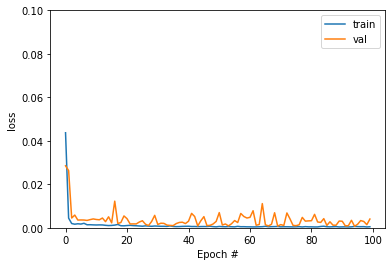

In [12]:
# Plot the losses during the training

plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='val')
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend()
plt.ylim(top=0.1,bottom=0)
plt.show()

In [13]:
# Need to denormalize the target variable in all the sets

## Train
y_train_min = train_data.min()[0]
y_train_max = train_data.max()[0]
y_pred_train = model.predict(X_train)

y_pred_train=y_pred_train[:, 0] * (y_train_max - y_train_min) + y_train_min
Y_train_denorm = Y_train * (y_train_max - y_train_min) + y_train_min

## Validation
y_val_min = val_data.min()[0]
y_val_max = val_data.max()[0]
y_pred_val = model.predict(X_val)

y_pred_val=y_pred_val * (y_val_max - y_val_min) + y_val_min
Y_val_denorm = Y_val * (y_val_max - y_val_min) + y_val_min

## Test
y_test_min = test_data.min()[0]
y_test_max = test_data.max()[0] 
y_pred_test = model.predict(X_test)

y_pred_test=y_pred_test * (y_test_max - y_test_min) + y_test_min
Y_test_denorm = Y_test * (y_test_max - y_test_min) + y_test_min

In [14]:
# Get MSE for each set of predictions

from sklearn.metrics import mean_squared_error

MSE_train = mean_squared_error(Y_train_denorm, y_pred_train)
MSE_val = mean_squared_error(Y_val_denorm, y_pred_val)
MSE_test = mean_squared_error(Y_test_denorm, y_pred_test)

print(f'MSE (train): {MSE_train.mean()}')
print(f'MSE (validation): {MSE_val.mean()}')
print(f'MSE (test): {MSE_test.mean()}')

MSE (train): 0.20913675387980513
MSE (validation): 0.8621265405738909
MSE (test): 4.248157413576217


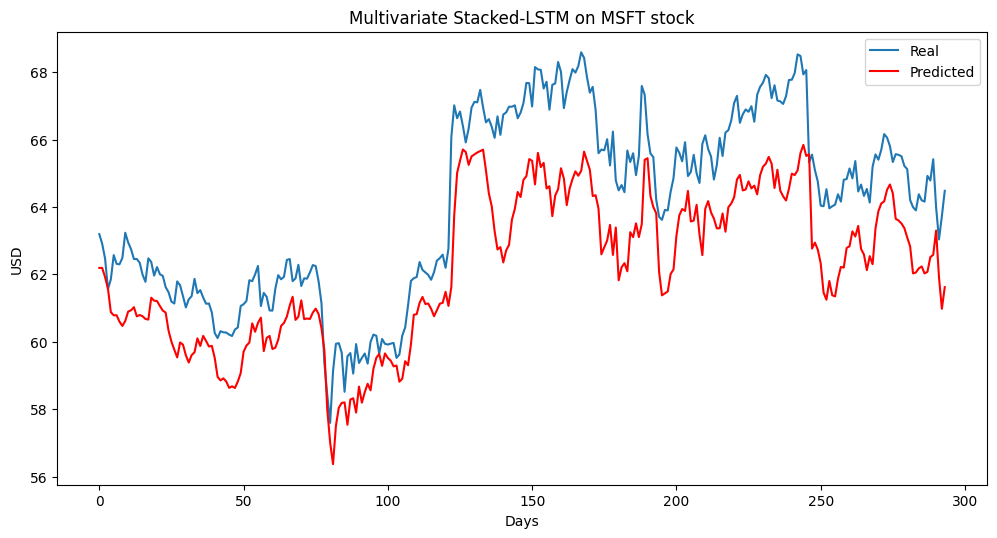

In [15]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(Y_test_denorm, label='Real')
plt.plot(y_pred_test, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Multivariate Stacked-LSTM on MSFT stock')
plt.legend()
plt.show()

Hyperparameter tuning of the model:

In [16]:
import sys
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM

# Will use Hyper-Opt to find the optimum parameters for the regressor

#Will set an EarlyStopping callback:
# - [monitor]: look at validation loss
# - [min_delta]: quantify the loss amount
# - [patience]: nr of epochs before stopping
# - [verbose]: what to print
# - [mode]: the direction we want to track (e.g. min, max)

def get_callbacks(pars):
  callbacks = [EarlyStopping(monitor = 'val_loss', 
                             min_delta = 0.001, 
                             patience = 2, 
                             verbose= 0, 
                             mode = 'auto')]
  return callbacks

# Defining the space in which fmin() will iterate:

space = {'neurons1': hp.choice('neurons1', [64, 128, 256]),
         'neurons2': hp.choice('neurons2', [64, 128, 256]),
         'lr': hp.choice('lr',[0.01, 0.001]),
         'activation_fn1': hp.choice('activation_fn1',['sigmoid','tanh','relu']),
         'activation_fn2': hp.choice('activation_fn2',['sigmoid','tanh','relu']),
         'dropout1': hp.choice('dropout1',[0,0.1,0.2]),
         'dropout2': hp.choice('dropout2',[0,0.1,0.2])
        }

def stacked_LSTM(pars):
  print('Parameters: ', pars)

  # Define the 2 neuron layers
  model = Sequential()
  model.add(LSTM(pars['neurons1'], 
                 activation = pars['activation_fn1'], 
                 return_sequences=True,
                 input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(pars['dropout1']))

  model.add(LSTM(pars['neurons2'], activation = pars['activation_fn2']))
  model.add(Dropout(pars['dropout2']))
  
  # Last unique linear activation for regression
  model.add(Dense(1, activation = 'linear'))

  # Define optimizer with learning rate as optimizable parameter 
  opt = Adam(lr = pars['lr'], decay = pars['lr'])
  
  # Compile the model
  model.compile(optimizer = opt, loss = 'mean_squared_error')

  # We now train the model
  history = model.fit(x=X_train, 
                      y=Y_train, 
					            validation_data=(X_val, Y_val),
	                    epochs = 10, 
                      batch_size = 32,
                      callbacks = get_callbacks(pars))
  
  # Save the losses and print them
  best_epoch_loss = np.argmin(history.history['val_loss'])
  best_val_loss = np.min(history.history['val_loss'])
  print('Epoch {} -  val loss: {}'.format(best_epoch_loss, best_val_loss))
  
  #This will let us see the progress while the script is running
  sys.stdout.flush()

  return {'loss': best_val_loss, 'best_epoch': best_epoch_loss, 
          'eval_time': time.time(), 'status': STATUS_OK, 'model': model, 
          'history': history}

trials = Trials()
# Use of fmin(), in which we put: 
#   - the defined function to minimize, 
#   - our space to iterate
#   - algorithm used: Tree of Parsen Estimators (TPE)
#   - maximum nr of evaluations 
#   - trials are used to see the results of each evaluation
best = fmin(stacked_LSTM, space, algo = tpe.suggest, max_evals = 10, trials = trials)
print(best)

Se han truncado las últimas 5000 líneas del flujo de salida.

 640/1338 [=============>................]
 - ETA: 1s - loss: 0.0097

 672/1338 [==============>...............]
 - ETA: 1s - loss: 0.0098

 704/1338 [==============>...............]
 - ETA: 1s - loss: 0.0101

 736/1338 [===============>..............]
 - ETA: 1s - loss: 0.0101

 768/1338 [================>.............]
 - ETA: 1s - loss: 0.0104

 800/1338 [================>.............]
 - ETA: 0s - loss: 0.0108

 832/1338 [=================>............]
 - ETA

In [20]:
trials.losses()

[0.007018471065923023,
 0.029135575505254203,
 0.007547732710532129,
 0.0068736845748626615,
 0.43021328604384645,
 0.011457427347410624,
 0.0976899834222173,
 0.3693208196391798,
 0.009608953703220372,
 0.0020158161976923275]

In [21]:
trials.trials[9]

{'book_time': datetime.datetime(2020, 8, 10, 2, 56, 24, 412000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'activation_fn1': [9],
   'activation_fn2': [9],
   'dropout1': [9],
   'dropout2': [9],
   'lr': [9],
   'neurons1': [9],
   'neurons2': [9]},
  'tid': 9,
  'vals': {'activation_fn1': [2],
   'activation_fn2': [1],
   'dropout1': [0],
   'dropout2': [1],
   'lr': [1],
   'neurons1': [2],
   'neurons2': [0]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2020, 8, 10, 2, 56, 42, 642000),
 'result': {'best_epoch': 4,
  'eval_time': 1597028202.6423833,
  'history': <keras.callbacks.callbacks.History at 0x7f417db597b8>,
  'loss': 0.0020158161976923275,
  'model': <keras.engine.sequential.Sequential at 0x7f417ddf1f60>,
  'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 9,
 'version': 0}

In [57]:
# Optimal results after hyperopt
# Will stick to ReLU and apply dropout to prevent overfitting. Reducing batch 
# size might report improvement on model generalization.

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, LeakyReLU
from keras.optimizers import Adam

lr=0.0001
epochs=200
opt = Adam(lr=lr, decay=lr/epochs)
batch_size=32

model = Sequential()
model.add(LSTM(256,return_sequences=True,
               input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LeakyReLU(0.05))
#model.add(Dropout(0.1))

model.add(LSTM(128, activation='relu'))
model.add(LeakyReLU(0.05))
#model.add(Dropout(0.1))

model.add(Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer=opt)

# train the model
print("[INFO] training model...")
model.fit(x=X_train, 
          y=Y_train, 
					validation_data=(X_val, Y_val),
					epochs=epochs, 
					batch_size=batch_size)

[INFO] training model...
Train on 1338 samples, validate on 292 samples
Epoch 1/200
1338/1338 [==============================] - 5s 4ms/step - loss: 0.0778 - val_loss: 0.4269
Epoch 2/200
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0221 - val_loss: 0.1398
Epoch 3/200
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 4/200
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0022 - val_loss: 0.0055
Epoch 5/200
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 6/200
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 7/200
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0020 - val_loss: 0.0074
Epoch 8/200
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 9/200
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0017 - val_loss: 0.0048
E

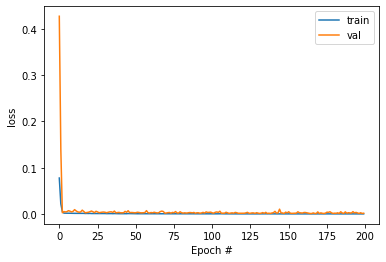

In [58]:
# Plot the losses during the training

plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='val')
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend()
#plt.ylim(top=1)
plt.show()

In [59]:
# Need to denormalize the target variable in all the sets

## Train
y_train_min = train_data.min()[0]
y_train_max = train_data.max()[0]
y_pred_train = model.predict(X_train)

y_pred_train=y_pred_train[:, 0] * (y_train_max - y_train_min) + y_train_min
Y_train_denorm = Y_train * (y_train_max - y_train_min) + y_train_min

## Validation
y_val_min = val_data.min()[0]
y_val_max = val_data.max()[0]
y_pred_val = model.predict(X_val)

y_pred_val=y_pred_val * (y_val_max - y_val_min) + y_val_min
Y_val_denorm = Y_val * (y_val_max - y_val_min) + y_val_min

## Test
y_test_min = test_data.min()[0]
y_test_max = test_data.max()[0] 
y_pred_test = model.predict(X_test)

y_pred_test=y_pred_test * (y_test_max - y_test_min) + y_test_min
Y_test_denorm = Y_test * (y_test_max - y_test_min) + y_test_min

In [60]:
# Get MSE for each set of predictions

from sklearn.metrics import mean_squared_error

MSE_train = mean_squared_error(Y_train_denorm, y_pred_train)
MSE_val = mean_squared_error(Y_val_denorm, y_pred_val)
MSE_test = mean_squared_error(Y_test_denorm, y_pred_test)

print(f'MSE (train): {MSE_train.mean()}')
print(f'MSE (validation): {MSE_val.mean()}')
print(f'MSE (test): {MSE_test.mean()}')

MSE (train): 0.22568826033562428
MSE (validation): 0.4120359265402001
MSE (test): 1.2658202848473326


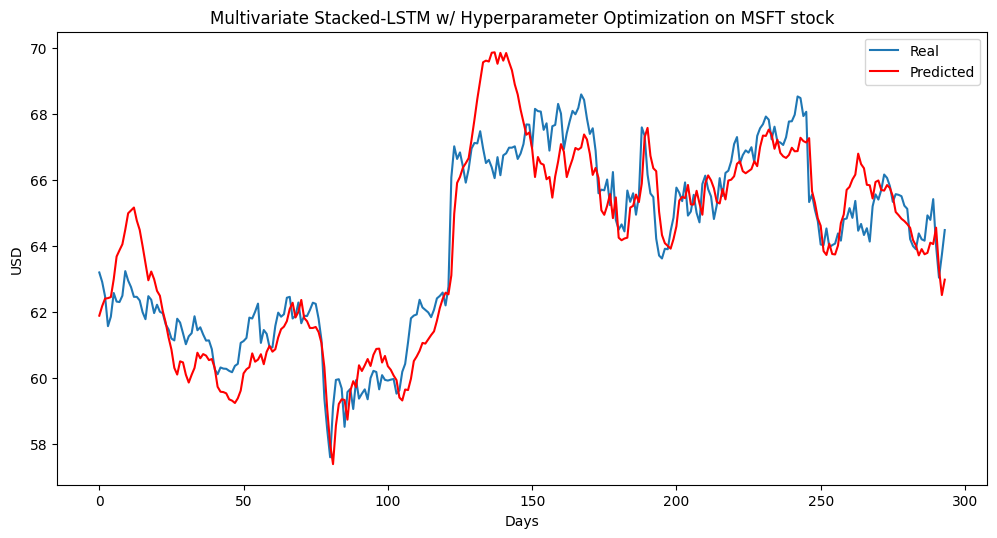

In [61]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(Y_test_denorm, label='Real')
plt.plot(y_pred_test, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Multivariate Stacked-LSTM w/ Hyperparameter Optimization on MSFT stock')
plt.legend()
plt.show()